In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc


In [2]:
df = pd.read_csv('/Users/shreysharma/Downloads/daily-min-temperatures.csv')

In [3]:
data = df.set_index(['Date'])
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


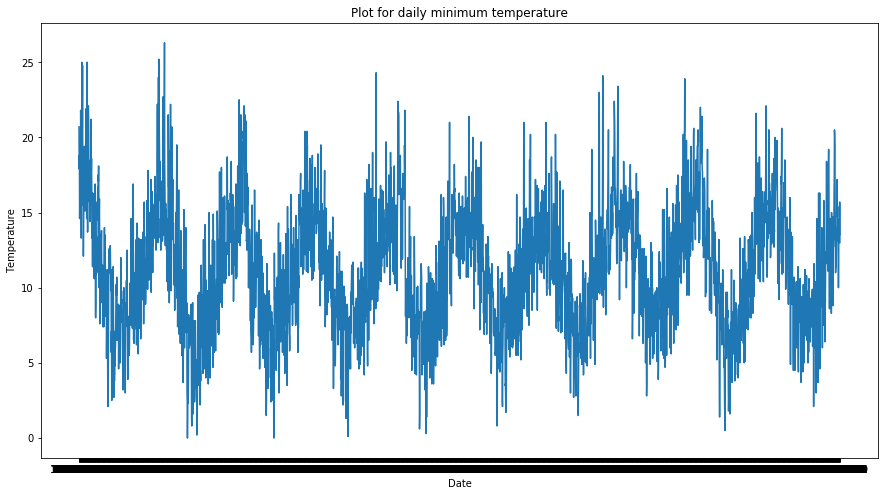

In [14]:
plt.figure(figsize=(15,8))
plt.plot(data.index,data.Temp)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Plot for daily minimum temperature')
plt.show()

## Lag plot

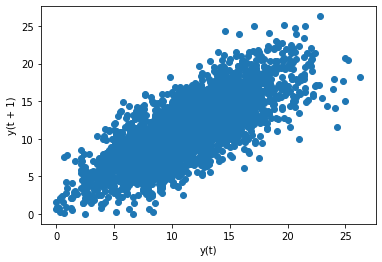

In [19]:
from pandas.plotting import lag_plot 
lag_plot(data)
plt.show()

Text(0.5, 1.0, 'Month-wise box plot')

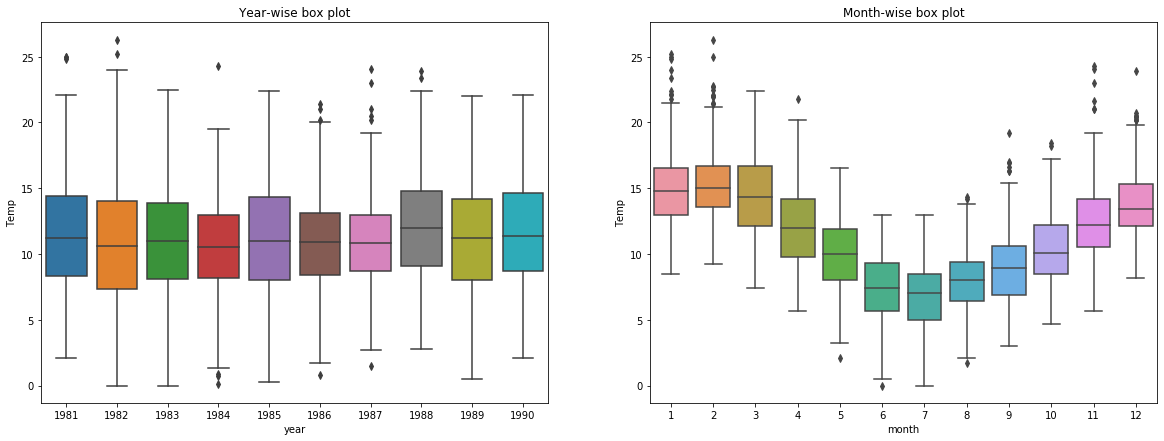

In [4]:
data['date'] = pd.to_datetime(data.index)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

fig, axes = plt.subplots(1, 2, figsize=(20,7))

ax1= sns.boxplot(x='year', y='Temp', data=data,ax=axes[0])
ax1.set_title('Year-wise box plot')
ax2= sns.boxplot(x='month',y='Temp',data= data,ax=axes[1])
ax2.set_title('Month-wise box plot')

## Stationarity of the time series

In [5]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [10]:
adfuller_test(data['Temp'], name='Temp')
print('\n')

    Augmented Dickey-Fuller Test on "Temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4448
 No. Lags Chosen       = 20
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.




In [6]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

2920 730


## ARIMA 

In [13]:
model_autoARIMA = auto_arima(train['Temp'], start_p=0, start_q=0,      
                      test='adf'       ,# using adftest to find optimal 'd'
                      max_p=5, max_q=5,# maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22714.455, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14246.469, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19612.896, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14158.348, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13961.999, Time=0.20 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13548.961, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13588.505, Time=0.60 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=13550.929, Time=0.95 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13590.061, Time=0.86 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13550.819, Time=0.82 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=13552.829, Time=0.84 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13538.735, Time=2.89 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13579.109, Time=2.05 sec
 ARIMA(3,0,0)(0,0,0)[0] i

predicted=14.280584, expected=14.300000
predicted=14.454804, expected=17.400000
predicted=16.213240, expected=18.500000
predicted=16.560163, expected=16.800000
predicted=15.596852, expected=11.500000
predicted=12.811708, expected=9.500000
predicted=12.179113, expected=12.200000
predicted=13.744837, expected=15.700000
predicted=15.282047, expected=16.300000
predicted=15.204771, expected=13.600000
predicted=13.635959, expected=12.600000
predicted=13.385471, expected=13.800000
predicted=14.129956, expected=12.100000
predicted=12.930418, expected=13.400000
predicted=13.821662, expected=17.300000
predicted=15.885965, expected=19.400000
predicted=16.735336, expected=16.600000
predicted=15.062233, expected=13.900000
predicted=13.979992, expected=13.100000
predicted=13.842830, expected=16.000000
predicted=15.563506, expected=14.500000
predicted=14.328489, expected=15.000000
predicted=14.821562, expected=12.600000
predicted=13.349945, expected=12.500000
predicted=13.519435, expected=15.200000
p

predicted=7.753295, expected=11.200000
predicted=8.775994, expected=8.000000
predicted=6.839963, expected=7.600000
predicted=7.141663, expected=3.700000
predicted=4.922035, expected=7.500000
predicted=7.591759, expected=8.100000
predicted=7.481688, expected=8.400000
predicted=7.666399, expected=7.100000
predicted=6.942218, expected=7.600000
predicted=7.440918, expected=7.600000
predicted=7.412246, expected=5.600000
predicted=6.252751, expected=7.000000
predicted=7.298436, expected=10.500000
predicted=9.205021, expected=7.300000
predicted=6.992191, expected=7.800000
predicted=7.744654, expected=5.800000
predicted=6.508450, expected=3.800000
predicted=5.513366, expected=5.800000
predicted=6.813487, expected=6.700000
predicted=7.018388, expected=6.600000
predicted=6.832968, expected=6.600000
predicted=6.842325, expected=9.000000
predicted=8.272934, expected=8.100000
predicted=7.521121, expected=5.100000
predicted=5.916407, expected=8.600000
predicted=8.326772, expected=7.000000
predicted=

predicted=17.664988, expected=17.000000
predicted=15.649597, expected=15.200000
predicted=15.073617, expected=16.500000
predicted=16.058350, expected=16.500000
predicted=15.923335, expected=17.300000
predicted=16.434302, expected=19.100000
predicted=17.465106, expected=19.300000
predicted=17.503113, expected=17.300000
predicted=16.453786, expected=19.000000
predicted=17.768512, expected=19.800000
predicted=18.132258, expected=19.300000
predicted=17.881170, expected=17.200000
predicted=16.818478, expected=14.200000
predicted=15.317416, expected=10.300000
predicted=13.243244, expected=13.000000
predicted=15.013217, expected=15.300000
predicted=15.823435, expected=15.000000
predicted=15.291036, expected=12.100000
predicted=13.564714, expected=9.200000
predicted=12.042107, expected=11.000000
predicted=13.172332, expected=15.000000
predicted=15.095009, expected=11.600000
predicted=12.559848, expected=11.600000
predicted=12.873749, expected=15.100000
predicted=14.812008, expected=15.000000
p

predicted=8.672297, expected=6.800000
predicted=7.994570, expected=5.200000
predicted=7.303576, expected=10.600000
predicted=10.528185, expected=16.300000
predicted=13.217094, expected=9.800000
predicted=8.899775, expected=4.600000
predicted=6.779402, expected=11.100000
predicted=11.139030, expected=8.700000
predicted=8.838744, expected=10.000000
predicted=9.927991, expected=11.300000
predicted=10.539418, expected=10.500000
predicted=9.973692, expected=9.900000
predicted=9.785792, expected=11.000000
predicted=10.537575, expected=14.000000
predicted=12.221913, expected=9.200000
predicted=9.154121, expected=9.800000
predicted=10.166484, expected=6.000000
predicted=7.801844, expected=9.800000
predicted=10.390227, expected=9.200000
predicted=9.473031, expected=11.800000
predicted=11.072455, expected=10.300000
predicted=9.915779, expected=7.500000
predicted=8.504028, expected=7.700000
predicted=8.904677, expected=15.800000
predicted=13.559756, expected=14.600000
predicted=11.987994, expecte

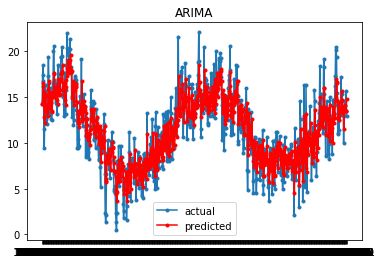

In [14]:
history = [x for x in train['Temp']]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history,order=(3,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Temp'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


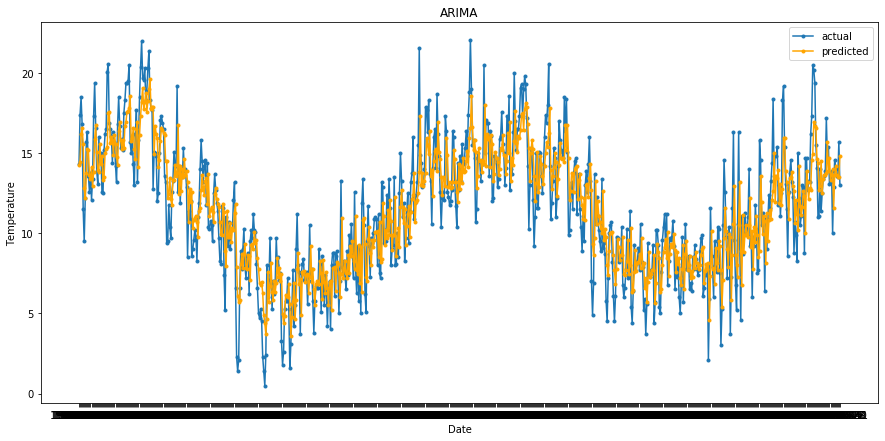

In [18]:
# plot
plt.figure(figsize=(15,7))
plt.title('ARIMA')
plt.plot(test['Temp'],label='actual',marker='.')
plt.plot(predictions,label='predicted',marker='.')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.show()

In [20]:
from math import sqrt
error = sqrt(mean_squared_error(test['Temp'], predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 2.207


## LSTM

In [7]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [8]:
# choose a number of time steps
n_steps = 10
# split into samples
train_X,train_y = split_sequence(train['Temp'], n_steps)
test_X,test_y = split_sequence(test['Temp'],n_steps)
print(train_X[0:5])
print(test_X[0:5])
train_X.shape

[[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]
 [17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2]
 [18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3]
 [14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7]
 [15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5]]
[[14.3 17.4 18.5 16.8 11.5  9.5 12.2 15.7 16.3 13.6]
 [17.4 18.5 16.8 11.5  9.5 12.2 15.7 16.3 13.6 12.6]
 [18.5 16.8 11.5  9.5 12.2 15.7 16.3 13.6 12.6 13.8]
 [16.8 11.5  9.5 12.2 15.7 16.3 13.6 12.6 13.8 12.1]
 [11.5  9.5 12.2 15.7 16.3 13.6 12.6 13.8 12.1 13.4]]


(2910, 10)

In [97]:
n_features=1
# define model
model =keras.Sequential()
model.add(keras.layers.LSTM(units=128, activation='relu', input_shape=(n_steps, n_features)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [98]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
# fit model
model.fit(train_X, train_y, epochs=40, verbose=0)
# demonstrate prediction
test_X = test_X.reshape((len(test_X), n_steps, n_features))
yhat = model.predict(test_X, verbose=0)

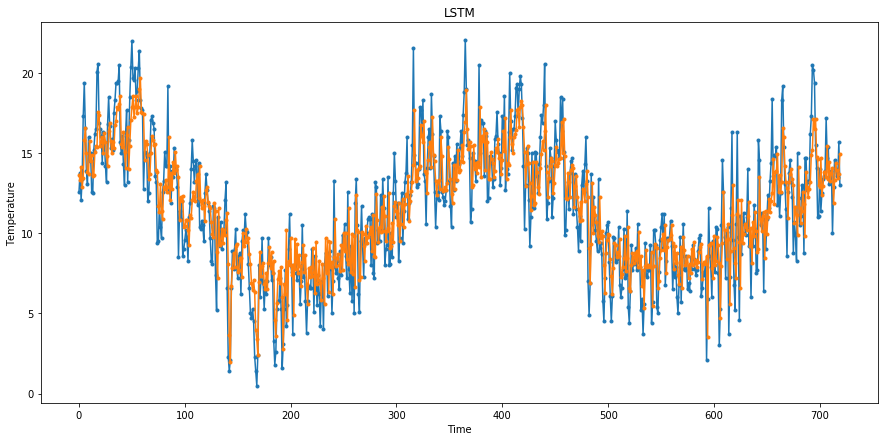

In [99]:
#plotting
plt.figure(figsize=(15,7))
plt.plot(test_y,label='Actual',marker='.')
plt.plot(yhat,label='Predicted',marker='.')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [100]:
rmse_lstm = sqrt(mean_squared_error(test_y,yhat))
print(f'The RMSE for LSTM is {rmse_lstm}')

The RMSE for LSTM is 2.203599581345778


## AR model

In [131]:
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
# split dataset
X = data['Temp'].values
train1, test1 = X[0:train_size], X[train_size:len(X)]

# train autoregression
model = AutoReg(train1, lags=500)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train1),end=len(train1)+len(test1)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test1[i]))


Coefficients: [ 4.17132043e+00  5.35604410e-01 -1.12173286e-01  5.37681303e-02
  4.45469549e-03  2.12367389e-02  2.73958192e-02  1.59277211e-02
  2.22654629e-02  1.34148373e-02 -5.68048289e-03  7.59074478e-03
  3.21604130e-03  7.74273639e-03 -3.94252878e-03  3.41981313e-02
 -9.42449499e-03  3.84901111e-03 -9.20216129e-05 -7.39694147e-03
  1.81892919e-02  1.01496635e-02  2.80256173e-02 -8.14265100e-03
 -8.06817918e-03  3.76832623e-03  3.37096336e-02  2.78948681e-02
 -1.96020464e-02 -5.81437456e-03 -5.10794207e-03  4.49155106e-02
 -4.99821100e-02  2.02180303e-02  1.55143118e-02  1.16844906e-02
 -2.67347461e-02 -1.48891157e-02  3.14747515e-02 -3.99241657e-03
  3.96902343e-03 -2.45698199e-02  1.37591124e-02 -3.92533488e-02
  3.42699480e-03  6.57174251e-03 -2.33943558e-02  2.95300092e-02
 -6.30021938e-03 -2.74355326e-02 -5.73655746e-03 -1.66669851e-02
  3.26072345e-02 -4.35584886e-02  4.93021038e-02  1.69141438e-02
 -2.16706432e-02 -3.76627949e-03  1.85288243e-03  3.07470466e-02
 -1.4820643

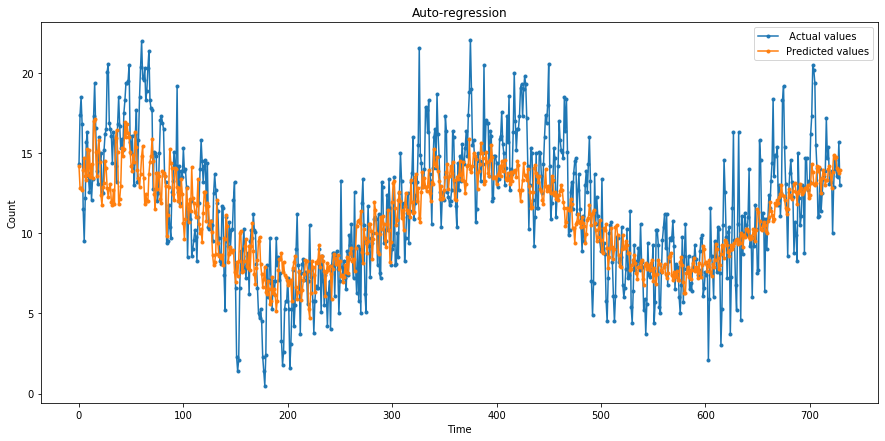

In [222]:
# plot results
plt.figure(figsize=(15,7))
plt.title('Auto-regression')
plt.plot(test1,label=' Actual values',marker='.')
plt.plot(predictions,label='Predicted values',marker='.')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

In [133]:
rmse_ar = sqrt(mean_squared_error(test1, predictions))
print('Test RMSE: %.3f' % rmse_ar)

Test RMSE: 2.866


## GPR

In [156]:
X_train=train[['year','month','day']]
y_train= train['Temp']
X_test = test[['year','month','day']]
y_test = test[['Temp']]

In [223]:
import sklearn.gaussian_process as gp

kernel = gp.kernels.ConstantKernel(2.0) * gp.kernels.RBF(0.1)

model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=True)
model.fit(X_train, y_train)
params = model.kernel_.get_params()

In [224]:
#Predictions
y_pred_gpr, std = model.predict(X_test,return_std=True)

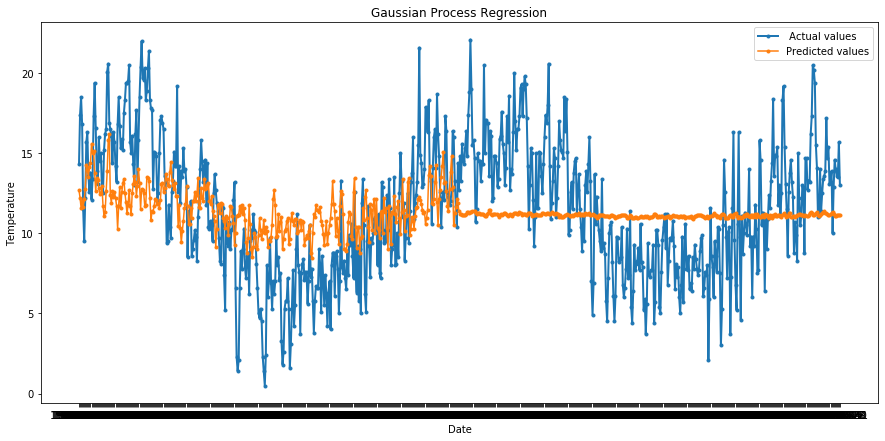

In [225]:
#plotting
plt.figure(figsize=(15,7))
plt.plot(y_test,label=' Actual values',marker='.',linewidth=2)
plt.plot(y_pred_gpr,label='Predicted values',marker='.')
plt.title('Gaussian Process Regression')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.show()

In [226]:
RMSE = sqrt(mean_squared_error(y_test, y_pred_gpr))
RMSE

3.8204488445799476

## Vector Auto Regression(VAR)

In [174]:
model = VAR(train[['year','month','day','Temp']])
x = model.select_order(maxlags=15)
x.summary()

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,11.19,11.20,7.268e+04,11.20
1,-11.60,-11.56*,9.192e-06,-11.58
2,-11.60,-11.52,9.190e-06,-11.57
3,-11.63,-11.52,8.919e-06,-11.59
4,-11.64,-11.50,8.787e-06,-11.59
5,-11.66,-11.48,8.659e-06,-11.59*
6,-11.67,-11.46,8.587e-06,-11.59
7,-11.67,-11.43,8.521e-06,-11.59
8,-11.68,-11.40,8.500e-06,-11.58
9,-11.68,-11.37,8.479e-06,-11.57


In [211]:
model_fitted = model.fit(300)
model_fitted.summary()

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/vector_ar/var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Aug, 2020
Time:                     01:01:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -8.54321
Nobs:                     2620.00    HQIC:                  -15.4092
Log likelihood:           15227.1    FPE:                5.53036e-09
AIC:                     -19.3081    Det(Omega_mle):     1.22250e-09
--------------------------------------------------------------------
Results for equation year
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -1.225395        10.945185           -0.112           0.911
L1.year          170.730295         5.002673           34.128           0.000
L1.month          14.139887         0.417001           33.909           0

In [212]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input =train[['year','month','day','Temp']].values[-lag_order:]
#forecast_input

300


In [213]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=test_size)
df_forecast = pd.DataFrame(fc, index=test[['year','month','day','Temp']].index[-test_size:],columns=['year','month','day','Temp'])
df_forecast

,year,month,day,Temp
Date,,,,
1989-01-01,1988.113885,10.784546,26.525584,17.484455
1989-01-02,1988.980159,1.242530,1.015471,16.279698
1989-01-03,1988.973825,1.322259,1.905954,15.833941
1989-01-04,1988.960424,1.468339,3.354532,13.815135
1989-01-05,1988.952556,1.554818,4.581853,15.536140
...,...,...,...,...
1990-12-27,1990.002591,11.893242,26.165956,13.950682
1990-12-28,1990.021487,11.646178,27.759490,13.985381
1990-12-29,1990.042836,11.408099,28.163956,13.871873


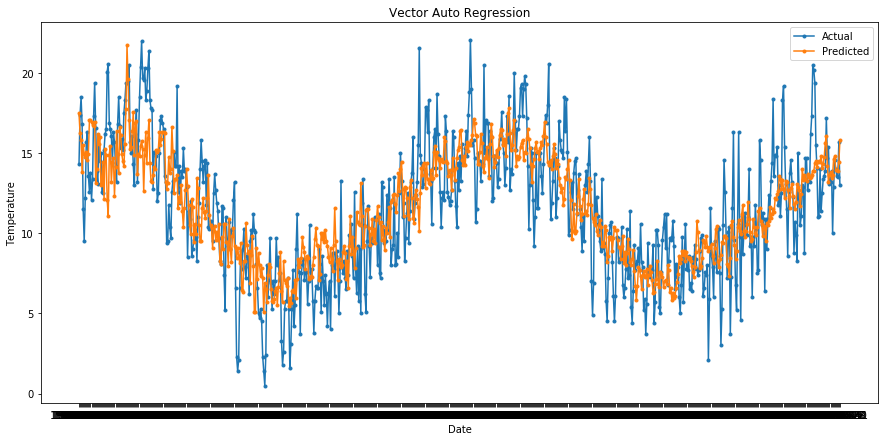

In [221]:
plt.figure(figsize=(15,7))
plt.plot(y_test,label='Actual',marker='.')
plt.plot(df_forecast['Temp'],label='Predicted',marker='.')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Vector Auto Regression')
plt.legend(loc='best')
plt.show()

In [215]:
#Calculating root mean squared error
rmse_var = sqrt(mean_squared_error(y_test, df_forecast['Temp']))
print('RMSE: %f' % rmse_var)

RMSE: 2.724053


## Bidirectional LSTM

In [84]:
n_features=1
#Bidirectional LSTM model
model =keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(30), merge_mode='concat', input_shape=(n_steps, n_features)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [85]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
# fit model
model.fit(train_X, train_y, epochs=40, verbose=0)
# demonstrate prediction
test_X = test_X.reshape((len(test_X), n_steps, n_features))
yhat = model.predict(test_X, verbose=0)

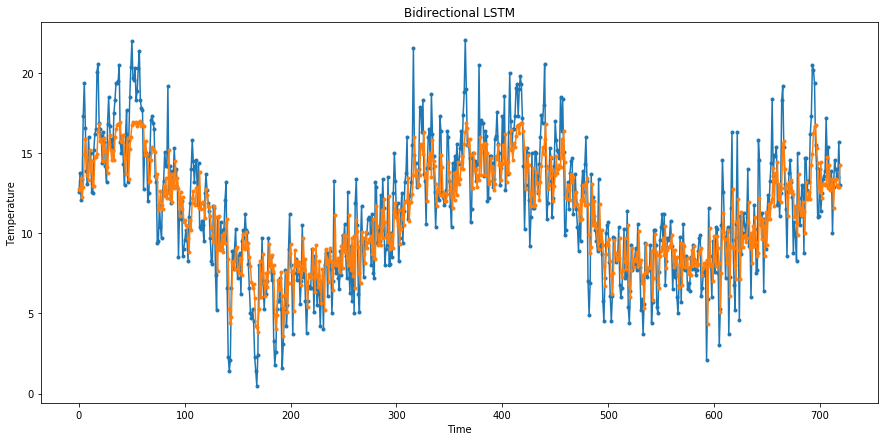

In [87]:
#plotting
plt.figure(figsize=(15,7))
plt.plot(test_y,label='Actual',marker='.')
plt.plot(yhat,label='Predicted',marker='.')
plt.title('Bidirectional LSTM')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [86]:
from math import sqrt
rmse_bi_lstm = sqrt(mean_squared_error(test_y,yhat))
print(f'The RMSE for bidirectional LSTM is {rmse_bi_lstm}')

The RMSE for bidirectional LSTM is 2.269346402237696


###### Cascaded bidirectional and unidirectional LSTM model

In [80]:
n_features=1
# define model
model =keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(30, input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True),merge_mode='concat'))
model.add(keras.layers.LSTM(64,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

In [81]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
# fit model
model.fit(train_X, train_y, epochs=40, verbose=0)
# demonstrate prediction
test_X = test_X.reshape((len(test_X), n_steps, n_features))
yhat = model.predict(test_X, verbose=0)

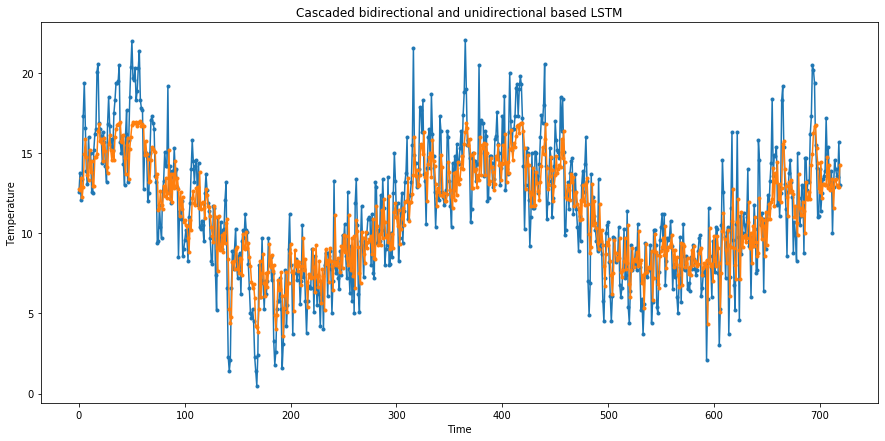

In [88]:
#plotting
plt.figure(figsize=(15,7))
plt.plot(test_y,label='Actual',marker='.')
plt.plot(yhat,label='Predicted',marker='.')
plt.title('Cascaded bidirectional and unidirectional based LSTM')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [82]:
#evaluating model performance
from math import sqrt
rmse_cas_lstm = sqrt(mean_squared_error(test_y,yhat))
print(f'The RMSE for LSTM is {rmse_cas_lstm}')

The RMSE for LSTM is 2.186115220829814


## Table of comparision

Models| Root Mean Square Error   |
----: |------------------------: | 
ARIMA |           2.207          |     
LSTM  |           2.203          |
AR    |           2.866          |
VAR   |           3.820          |
GPR                                            |           2.724          |
Bidirectional LSTM                             |           2.269          |
Cascaded bidirectional and unidirectional LSTM |           2.186          |

> From the above table of comparision, it can be noted that for Minimum temperature dataset, __Cascaded bidirectional and unidirectional based LSTM model__ performs better in comparision to other models with 30 bidirectional layers, 64 unidirectional layers, relu activation and rmsprop optimizer, with RMSE value of 2.186